#### Set up the environment

In [2]:
import numpy as np
import pandas as pd
import os
from glob import glob
import pathlib
import shutil
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from PIL import Image as pillow

Will be using the expanded dataset for potentially better generalization

In [4]:
directory2 = "brain_tumor 2/test/"
pixel2 = []
target2 = []

for dataclass in glob(directory2+'/*'):
    for file in glob(dataclass+'/*'):
        pixels = mpl.image.imread(file)
        pixel2.append(pixels) 
        target2.append(dataclass.split("/")[-1])
        
directory3 = "brain_tumor 2/training/"

for dataclass in glob(directory3+'/*'):
    for file in glob(dataclass+'/*'):
        pixels = mpl.image.imread(file)
        pixel2.append(pixels) 
        target2.append(dataclass.split("/")[-1])

In [5]:
df2 = pd.DataFrame({'image': pixel2,'target': target2})
df2["target"] = df2.target.str.replace("pred","test_set")
len(df2)

8976

With additional set of data, 65% of the final dataset (c. 9000 images) is positive class and 35% is negative

([<matplotlib.patches.Wedge at 0x7ff726a23700>,
 [Text(-0.5139468846762569, 0.972552620546349, 'yes'),
  Text(0.5139468846762568, -0.972552620546349, 'no')],
 [Text(-0.2803346643688674, 0.5304832475707357, '65%'),
  Text(0.2803346643688673, -0.5304832475707357, '35%')])

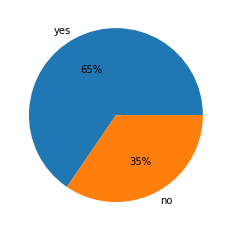

In [6]:
plt.pie(df2[df2.target!="test_set"].target.value_counts(), labels=['yes','no'], autopct='%0.0f%%')

In [3]:
train_dir = pathlib.Path("brain_tumor 2/training")
test_dir = pathlib.Path("brain_tumor 2/validation")
pred_dir = pathlib.Path("brain_tumor 2/test")

batch = 256
img_height = 224
img_width = 224
img_size = (img_height, img_width)

Image augmentation applied to the training dataset for generalization

In [7]:
imagegenerator = image.ImageDataGenerator(rescale=1./255,
                                          rotation_range=30,
                                          width_shift_range=15,
                                          height_shift_range=15,
                                          brightness_range=[0.5, 1.5],
                                          horizontal_flip=True,
                                          vertical_flip=True)
imggen = image.ImageDataGenerator(rescale=1./255)

In [8]:
train_gen = imagegenerator.flow_from_directory(
    train_dir,
    batch_size=batch,
    target_size=img_size,
    seed=2021,
    color_mode='rgb',
    class_mode='binary'
)

test_gen = imggen.flow_from_directory(
    test_dir,
    batch_size=batch,
    target_size=img_size,
    color_mode='rgb',
    class_mode='binary'
)

pred_gen = imggen.flow_from_directory(
    pred_dir,
    batch_size=batch,
    target_size=img_size,
    color_mode='rgb',
    class_mode='binary',
    shuffle=False
)

Found 7465 images belonging to 2 classes.
Found 1047 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer
from tensorflow.keras import optimizers

In [11]:
model_expand = Sequential()

model_expand.add(InputLayer(input_shape=(224,224,3)))

model_expand.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
model_expand.add(MaxPooling2D())

model_expand.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))

model_expand.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))

model_expand.add(Conv2D(filters=64, kernel_size=5, activation='relu', padding='same'))
model_expand.add(MaxPooling2D())

model_expand.add(Conv2D(filters=10, kernel_size=7, activation='relu', padding='same'))
model_expand.add(Flatten())
model_expand.add(Dense(1, activation='sigmoid'))

model_expand.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_expand.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 10)        3

2022-01-18 15:44:13.147329: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-18 15:44:13.148364: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
from tensorflow.keras.callbacks import EarlyStopping
result_expand = model_expand.fit_generator(
    train_gen,
    validation_data=test_gen,
#     steps_per_epoch=100,
    epochs=100,
    callbacks=[EarlyStopping(patience=10, verbose=1)]
)

Epoch 1/100
30/30 [==============================] - 1322s 44s/step - loss: 0.6234 - accuracy: 0.7328 - val_loss: 0.5471 - val_accuracy: 0.7230
Epoch 2/100
30/30 [==============================] - 1243s 41s/step - loss: 0.3905 - accuracy: 0.8269 - val_loss: 0.5122 - val_accuracy: 0.7775
Epoch 3/100
30/30 [==============================] - 1206s 40s/step - loss: 0.2930 - accuracy: 0.8770 - val_loss: 0.4838 - val_accuracy: 0.8099
Epoch 4/100
30/30 [==============================] - 1234s 41s/step - loss: 0.2303 - accuracy: 0.9084 - val_loss: 0.4812 - val_accuracy: 0.8500
Epoch 5/100
30/30 [==============================] - 1264s 42s/step - loss: 0.1912 - accuracy: 0.9283 - val_loss: 0.5968 - val_accuracy: 0.8309
Epoch 6/100
30/30 [==============================] - 1285s 43s/step - loss: 0.1463 - accuracy: 0.9504 - val_loss: 0.4077 - val_accuracy: 0.8720
Epoch 7/100
30/30 [==============================] - 1435s 48s/step - loss: 0.1114 - accuracy: 0.9633 - val_loss: 0.3554 - val_accuracy:

In [5]:
predictions = model_expand.predict(pred_gen, verbose=1)

2021-12-02 22:55:01.841028: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


6/6 [==============================] - 68s 11s/step


Classification metrics show a slight drop from near 100% to 97% in accuracy - but maybe in the range where I'm comfortable to say that the model does generalize

In [6]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

print(accuracy_score(pred_gen.classes, predictions.round(0)))
print(recall_score(pred_gen.classes, predictions.round(0)))

0.9735274652547982
0.9701789264413518


In [22]:
model_expand.save("custom_cnn_expanded_data.h5")

In [4]:
model_expand = tf.keras.models.load_model("custom_cnn_expanded_data.h5")

2021-12-02 22:54:58.038125: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-02 22:54:58.038498: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
